In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os
import sys
import configparser
sys.path.append(os.path.join('..'))
from physics215ProjectCode import reconstruct_signal as rs
from physics215ProjectCode import error_fn
from physics215ProjectCode import configParser as cP

# plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

In [2]:
configpath = '../configs/config1.ini'
category = 'Figure1ExeSummary'

config = cP.parseConfig(configpath, category)

In [3]:
n = int(config['n'])
initial_frequency = eval(config['initial_frequency'])
increments = eval(config['increments'])
final_frequency = eval(config['final_frequency'])
t_end = int(config['t_end'])
t = np.linspace(0,t_end,n)
p = eval(config['p'])

In [4]:

frequencies = np.arange(initial_frequency, final_frequency + 1, increments)
no_of_waves = np.arange(1,len(frequencies)+1)
t = np.linspace(0,1,n)
frequency_x = np.arange(0,n)

orig_signal_per_f = []

In [5]:
for f_iter in frequencies:
    orig_signal_per_f.append(rs.make_signal(n, initial_frequency, f_iter, increments))

PSD of original signal:

In [7]:
PSD_orig = []

In [8]:
for signal_iter in orig_signal_per_f:
    PSD_orig.append(rs.PSD(signal_iter))

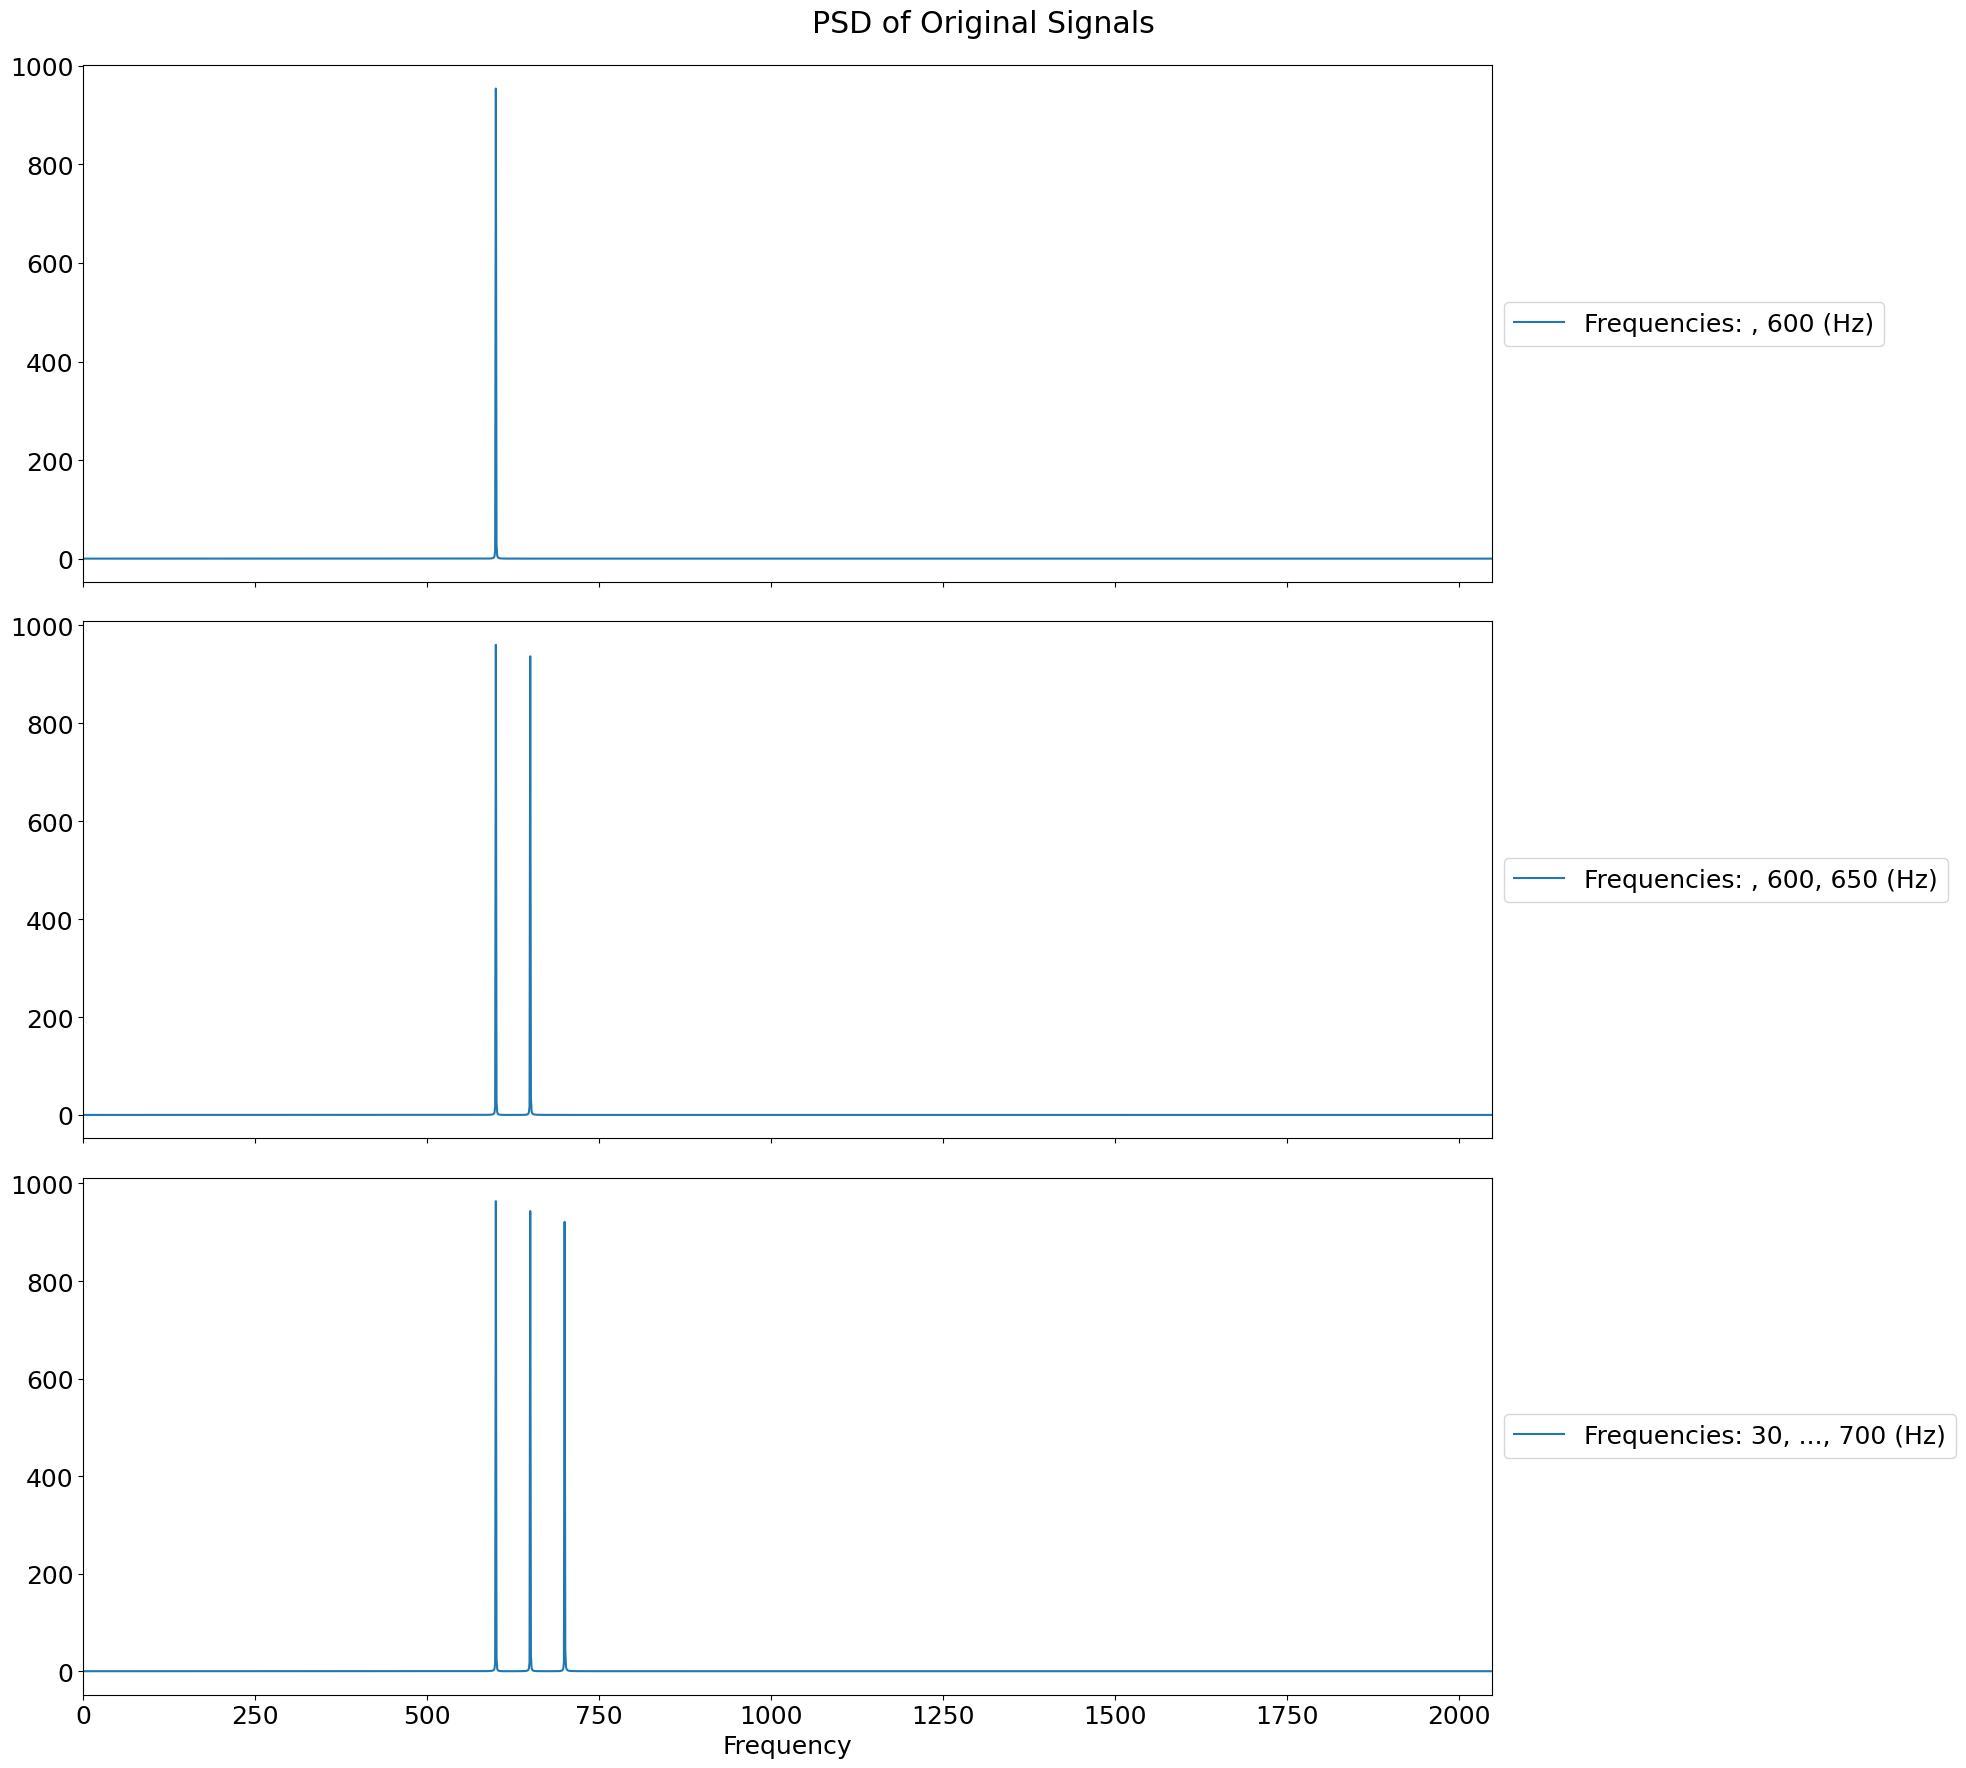

In [9]:
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 18})

fig,axs = plt.subplots(len(frequencies),1)
axs = axs.reshape(-1)
ylim = (-2,2)
ylim_uni = (ylim[0]*3000, ylim[1]*3000)
legend = "Frequencies: "

for i, pt in enumerate(frequencies):
    if i <= 1:
        if pt == 30:
            legend += str(pt)
        else:
            legend += ", " + str(pt)
    else:
        legend = "Frequencies: 30, ..., " + str(pt)
    axs[i].plot(abs(PSD_orig[i]), label = legend + " (Hz)")
    axs[i].set_xlim(0,n/2)
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if i != len(axs) - 1:
        axs[i].set_xticklabels([])  # Hide x-tick labels

fig.suptitle("PSD of Original Signals")
plt.xlabel("Frequency")
plt.tight_layout(rect=[0, -0.5, 1, 1.01])
plt.show()

Plotting reconstructed above Nyquist frequency:

The same for all p

In [10]:
reg_recon_per_f = []

In [11]:
for f_iter in orig_signal_per_f:
    signal_recon = rs.nyquist_reconstruction(final_frequency * 2, f_iter)

    n_low = len(signal_recon)
    t_low = np.linspace(0, 1, n_low)
    
    interp_fn = interp1d(t_low, signal_recon, kind='cubic') # interpolate reconstructed signal to match resolution of original signal
    signal_high = interp_fn(t)
    reg_recon_per_f.append(signal_high)

Plotting PSD of above Nyquist reconstruction:

In [13]:
PSD_reg = []

In [14]:
for signal_iter in reg_recon_per_f:
    PSD_reg.append(rs.PSD(signal_iter))

In [16]:
sub_recon_per_p = []

In [17]:
for p_iter in p:
    sub_recon_per_f = []
    for f_iter in orig_signal_per_f:
        sub_recon_per_f.append(rs.sub_nyquist_reconstruction(p_iter, f_iter))
    sub_recon_per_p.append(sub_recon_per_f)

Iteration 41

Plotting PSD of sub-Nyquist reconstruction:

In [19]:
PSD_sub = []

In [20]:
for p_iter in sub_recon_per_p:
    PSD_sub_per_f = []
    for signal_iter in p_iter:
        PSD_sub_per_f.append(rs.PSD(signal_iter))
    PSD_sub.append(PSD_sub_per_f)

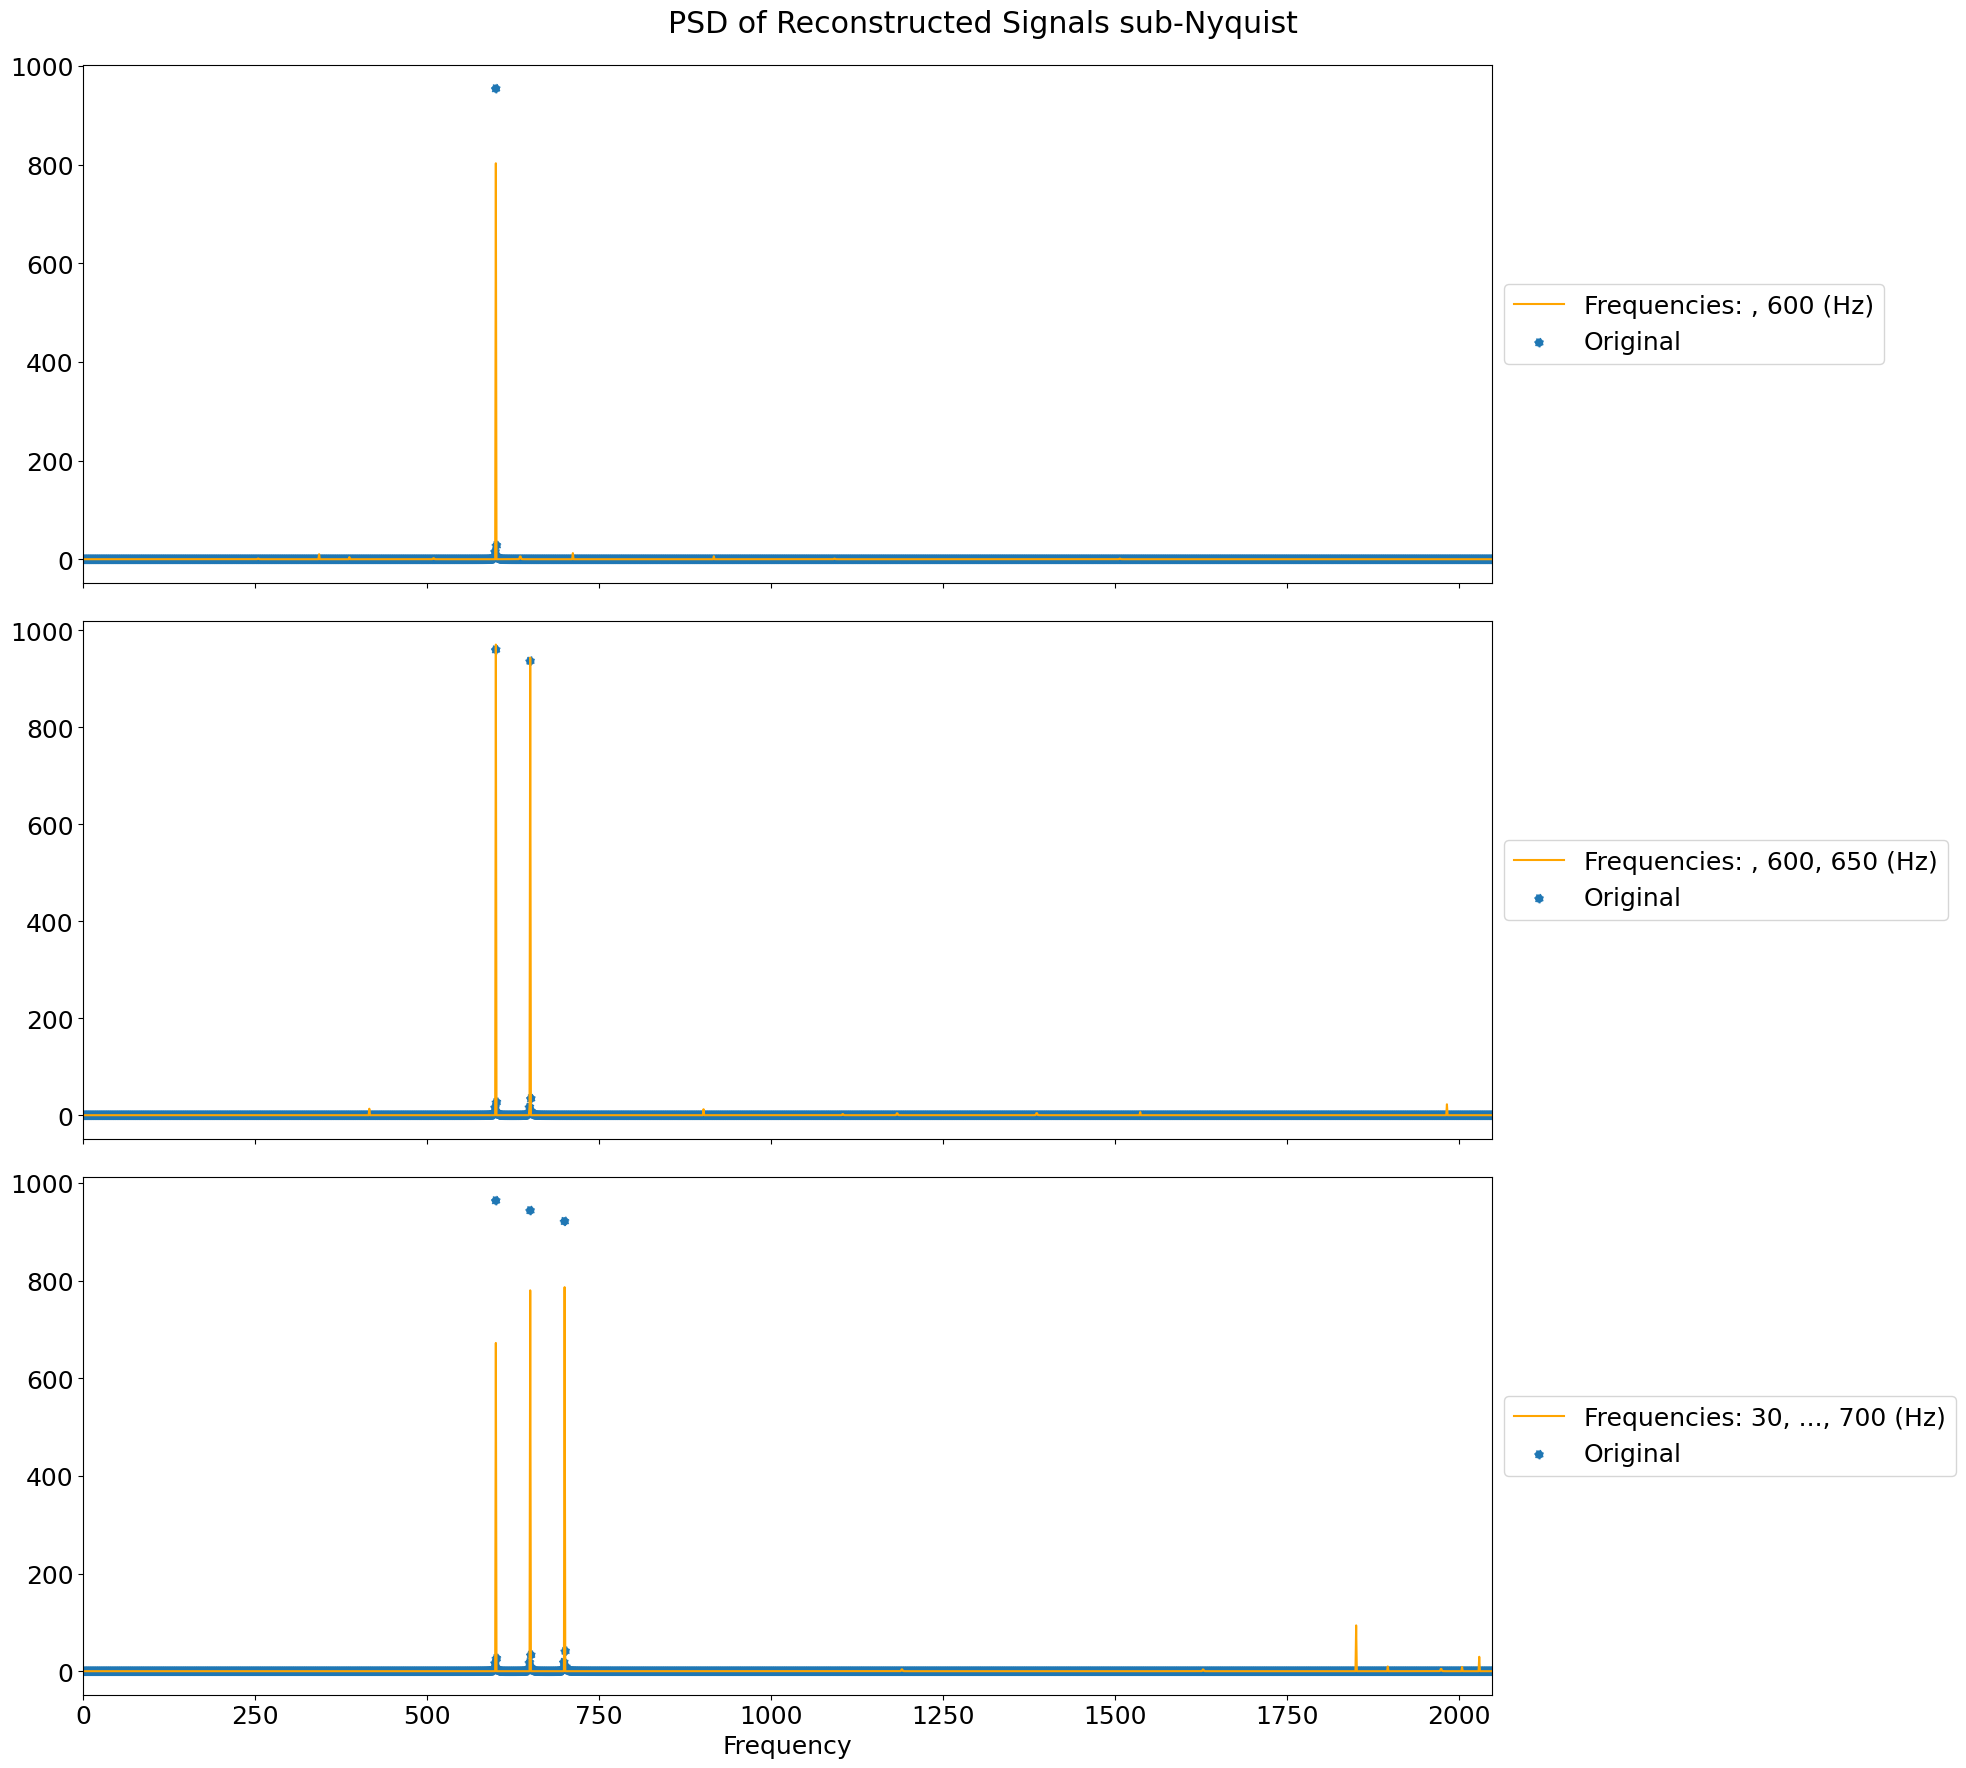

In [21]:
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 18})

fig,axs = plt.subplots(len(frequencies),1)
axs = axs.reshape(-1)
ylim = (-2,2)
ylim_uni = (ylim[0]*3000, ylim[1]*3000)
legend = "Frequencies: "

for i, pt in enumerate(frequencies):
    if i <= 1:
        if pt == 30:
            legend += str(pt)
        else:
            legend += ", " + str(pt)
    else:
        legend = "Frequencies: 30, ..., " + str(pt)
    axs[i].plot(abs(PSD_sub[3][i]), label = legend + " (Hz)", color = "orange")
    axs[i].scatter(frequency_x, abs(PSD_orig[i]), label="Original", color="#1f77b4", linestyle='dotted')  # Original signal
    axs[i].set_xlim(0,n/2)
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if i != len(axs) - 1:
        axs[i].set_xticklabels([])  # Hide x-tick labels

fig.suptitle("PSD of Reconstructed Signals sub-Nyquist")
plt.xlabel("Frequency")
plt.tight_layout(rect=[0, -0.5, 1, 1.01])
plt.show()

In [22]:
print(np.arange(0,4))

[0 1 2 3]


Error of reconstructed signal compared to original. Blue is above Nyquist frequency. Orange is sub-Nyquist.

Number of uniformly-spaced sample points for above Nyquist frequency sampling n = 1260

In [23]:
err_reg_signal = []
err_sub_signal = []
err_reg_PSD = []
err_sub_PSD = []

In [24]:
for i, signal_iter in enumerate(reg_recon_per_f):
    err_signal = error_fn.normalized_rmse(orig_signal_per_f[i], signal_iter)
    err_PSD = error_fn.normalized_rmse(PSD_orig[i], PSD_reg[i])
    err_reg_signal.append(err_signal)
    err_reg_PSD.append(err_PSD)

for i1, p_iter in enumerate(sub_recon_per_p):
    err_sub_signal_per_f = []
    err_sub_PSD_per_f = []
    for i2, signal_iter in enumerate(p_iter):
        err_signal = error_fn.normalized_rmse(orig_signal_per_f[i2], signal_iter)
        err_PSD = error_fn.normalized_rmse(PSD_orig[i2], PSD_sub[i1][i2])
        err_sub_signal_per_f.append(err_signal)
        err_sub_PSD_per_f.append(err_PSD)
    err_sub_signal.append(err_sub_signal_per_f)
    err_sub_PSD.append(err_sub_PSD_per_f)

### Single Wave statistics

In [25]:
aboveNyquist_error = err_reg_signal[0]
subNyquist_errors = np.array([err_sub_signal[i][0] for i in range(len(err_sub_signal))])

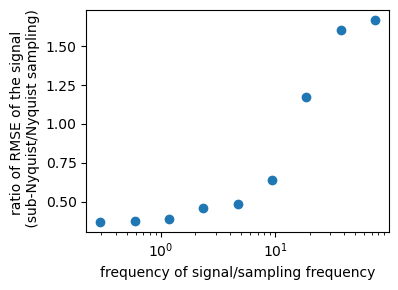

In [26]:
plt.rcParams['figure.figsize'] = [4,3]
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots()

# Plot using the ax object
ax.scatter(np.array(initial_frequency)/p, subNyquist_errors / aboveNyquist_error)

# Label axes
ax.set_ylabel('ratio of RMSE of the signal \n (sub-Nyquist/Nyquist sampling)')
ax.set_xlabel('frequency of signal/sampling frequency')

# Set scale
# ax.set_yscale('log')  # Uncomment if needed
ax.set_xscale('log')

# Layout and save
fig.tight_layout()
fig.savefig('../readme_images_src_new/singleWaveStats.jpg', format='jpg', dpi=300)